<a href="https://colab.research.google.com/github/brokentwigs/Colab-Analysis/blob/main/FinalModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time

# visualizatoin
import matplotlib.pyplot as plt
import seaborn as sns

# data wrangling
import pandas as pd
import numpy as np

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
import category_encoders as ce

#feature selection algorithms
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score, roc_curve

#validation
from sklearn.model_selection import cross_val_score




#machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#evaluation metrics for machine learning algorithms
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, RandomizedSearchCV,GridSearchCV

#optimization
from numpy import argmax






import warnings
warnings.filterwarnings("ignore")

In [ ]:
#!pip install category_encoders run this first


In [ ]:
# description
description = pd.read_csv('WiDS_Datathon_2020_Dictionary.csv') #read data
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('training_v2.csv')

#print_full(description)
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
# Returns category description

def category(description, string):

    return description[description.Category==string]

# Returns highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
# Parameter definitions
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [ ]:
X = df.copy().drop(['hospital_death'], axis=1)
y = df['hospital_death'].copy()
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache,
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        )
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test,
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        )

In [ ]:
apache_cov = category(description,"APACHE covariate")
vitals = category(description,"vitals")
labs = category(description,"labs")

corr_features_apache_cov = correlation(X_train[apache_cov["Variable Name"]], 0.85)
corr_features_vitals = correlation(X_train[vitals["Variable Name"]], 0.85)
corr_features_labs = correlation(X_train[labs["Variable Name"]], 0.85)

In [ ]:
to_drop = set()
to_drop.update(['apache_2_bodysystem', 'apache_4a_icu_death_prob', 'encounter_id', 'patient_id', 'weight', 'height',
                'icu_stay_type', 'readmission_status', 'hospital_id', 'icu_id',
                'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
to_drop.update(corr_features_apache_cov)
to_drop.update(corr_features_vitals)
to_drop.update(corr_features_labs)

In [ ]:
X_train = X_train.drop(to_drop, axis=1)
X_val = X_val.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [ ]:
 """MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

In [ ]:
def customprocessor(X, y):
    num = [col for col in X.columns if X[col].dtypes != 'O' and ~X[col].isin([0.0,1.0,np.nan]).all()]
    cat = [col for col in X.columns if X[col].dtypes == 'O' or X[col].isin([0.0,1.0,np.nan]).all()]

    # Imputing numerical values
    linearreg = LinearRegression()
    imp = IterativeImputer(estimator=linearreg, missing_values=np.nan, max_iter=5, imputation_order='roman', verbose=2, random_state=42)
    X[num] = imp.fit_transform(X[num])

    # Imputing categorical values
    impcat = SimpleImputer(strategy="most_frequent")
    X[cat] = impcat.fit_transform(X[cat])

    # Turn 'gender' column into a binary column
    gender = {'M': 1,'F': 0}
    X.gender = [gender[item] for item in X.gender]

    # Target encoding with additive smoothing
    def calc_smooth_mean(X, y, by, on, m):
        df = pd.concat([X, y], axis=1)

        # Compute the global mean
        mean = df[on].mean()

        # Compute the number of values and the mean of each group
        agg = df.groupby(by)[on].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']

        # Compute the "smoothed" means
        smooth = (counts * means + m * mean) / (counts + m)

        # Replace each value by the according smoothed mean
        return X[by].map(smooth)

    X['ethnicity'] = calc_smooth_mean(X, y, by='ethnicity', on='hospital_death', m=10)
    X['hospital_admit_source'] = calc_smooth_mean(X, y, by='hospital_admit_source', on='hospital_death', m=10)
    X['icu_admit_source'] = calc_smooth_mean(X, y, by='icu_admit_source', on='hospital_death', m=10)
    X['icu_type'] = calc_smooth_mean(X, y, by='icu_type', on='hospital_death', m=10)
    X['apache_3j_bodysystem'] = calc_smooth_mean(X, y, by='apache_3j_bodysystem', on='hospital_death', m=10)

    return X


In [ ]:
# Applying pre-processing steps
X_train = customprocessor(X_train, y_train)
X_val = customprocessor(X_val, y_val)
X_test = customprocessor(X_test, y_test)

[IterativeImputer] Completing matrix with shape (5967, 87)
[IterativeImputer] Ending imputation round 1/5, elapsed time 6.27
[IterativeImputer] Change: 1338.9726263772034, scaled tolerance: 2.2010500000000004 
[IterativeImputer] Ending imputation round 2/5, elapsed time 10.78
[IterativeImputer] Change: 1128.4065242372099, scaled tolerance: 2.2010500000000004 
[IterativeImputer] Ending imputation round 3/5, elapsed time 17.33
[IterativeImputer] Change: 623.6599703844029, scaled tolerance: 2.2010500000000004 
[IterativeImputer] Ending imputation round 4/5, elapsed time 26.07
[IterativeImputer] Change: 227.16640307930595, scaled tolerance: 2.2010500000000004 
[IterativeImputer] Ending imputation round 5/5, elapsed time 35.96
[IterativeImputer] Change: 133.46599021591373, scaled tolerance: 2.2010500000000004 
[IterativeImputer] Completing matrix with shape (746, 87)
[IterativeImputer] Ending imputation round 1/5, elapsed time 2.19
[IterativeImputer] Change: 758.0426237393476, scaled tolera

Hyperparamter tuning, model selection, tresholds, ROC curve, Evaluation Metrics

In [ ]:
 def random_search(model, X, Y, n_splits=10, n_repeats=3):

    """
  Random search for hyperparameter tuning:
  model - Random Forest classifier, DecisionTrees
  X - Data matrix X, typically training data
  Y - Target vector Y, typically training labels/binary
  n_splits - splits to be made in repeated stratified kfold cv
  n_repeats - number of times to repeat stratified kfold cv
  Note --> The Search spaces are preset/defined randomly
      """
    if type(model) == type(RandomForestClassifier()):
        params = dict(
        n_estimators= [100,150],
        criterion = ['gini', 'entropy'],
        min_samples_split = [2, 3, 4],
        min_samples_leaf = [1, 2, 3, 4, 5],
        max_features = ['auto', 'sqrt'],
        max_depth = [5, 6, 7]
        )

    elif type(model) == type(DecisionTreeClassifier()):
        params = dict(
        criterion = ['gini', 'entropy'],
        min_samples_split = [2, 3, 4],
        min_samples_leaf = [1, 2, 3, 4, 5],
        max_depth = [5, 6, 7])



    elif type(model) == type(xgboost.XGBClassifier()):
        params = dict(gamma = [0.1, 0.5, 2, 6, 25, 100],
                      learning_rate = [0.01, 0.03, 0.06, 0.1, 0.2, 0.3],
                      max_depth = [5, 10, 15, 20],
                      n_estimators = [50, 80, 115, 150],
                      reg_alpha = [0.1, 0.5, 2, 6, 25, 100],
                      reg_lambda = [0.1, 0.5, 2, 6, 25, 100])



      # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)


    #random search

    search = RandomizedSearchCV(model, params,  n_iter=100, scoring='accuracy', n_jobs=-1, cv=cv)


    # execute search
    result = search.fit(X, Y)
    print('SEARCH COMPLETE')



    # return the best result
    return result.best_score_ , result.best_params_


In [ ]:
 def decision_classifier(X_train,y_train):
    params={
    'min_samples_split':3,
    'min_samples_leaf':3,
    'max_depth':6,
    'criterion':'gini'}

    w = {0:9, 1:91}


    dt = DecisionTreeClassifier(**params, class_weight = w)
    dt.fit(X_train, y_train)
    dt_preds = dt.predict(X_test)

    print("Accuracy TEST SET:",metrics.accuracy_score(y_test, dt_preds))


    print("The precision, recall and f1 score:", precision_recall_fscore_support(y_test, dt_preds, average='binary'))
    print('The balanced accuracy:',balanced_accuracy_score(y_test, dt_preds))

decision_classifier(X_train,y_train)

Accuracy TEST SET: 0.7855227882037533
The precision, recall and f1 score: (0.1724137931034483, 0.6521739130434783, 0.27272727272727276, None)
The balanced accuracy: 0.7232298136645963


In [ ]:
 #sum of weight for the xgboost classifier, he does not have the class weight
y_train_0 = []
y_train_1 = []
for i in y_train:
    if i == 0:
        y_train_0.append(i)
    elif i == 1:
        y_train_1.append(i)

weight = len(y_train_0) / len(y_train_1)
weight

def xg_boost(X_train,y_train):
    params = params={
    'reg_lambda':25,
    'reg_alpha':2,
    'n_estimators':115,
    'max_depth': 20,
    'learning_rate':0.1,
    'gamma':6}


    xg = XGBClassifier(**params, scale_pos_weight=weight) # Init model
    xg.fit(X_train, y_train) # Fit model
    xg_preds = xg.predict(X_test.astype(int)) # Get model inference

    print("Accuracy TEST SET:",metrics.accuracy_score(y_test, xg_preds))


    print("The precision, recall and f1 score:", precision_recall_fscore_support(y_test, xg_preds, average='binary'))
    print('The balanced accuracy:',balanced_accuracy_score(y_test, xg_preds))




xg_boost(X_train.astype(int),y_train)

Accuracy TEST SET: 0.9168900804289544
The precision, recall and f1 score: (0.38235294117647056, 0.5652173913043478, 0.45614035087719296, None)
The balanced accuracy: 0.7526086956521738


In [ ]:
def random_forest(X_train,y_train):
  params = {'n_estimators': 150,
  'min_samples_split': 2,
  'min_samples_leaf': 4,
  'max_features': 'auto',
  'max_depth': 7,
  'criterion': 'gini'}

  w = {0:9, 1:91}


  rf = RandomForestClassifier(**params, class_weight = w)
  rf.fit(X_train, y_train)
  rf_preds = rf.predict(X_test)

  print("Accuracy TEST SET:",metrics.accuracy_score(y_test, rf_preds))


  print("The precision, recall and f1 score:", precision_recall_fscore_support(y_test, rf_preds, average='binary'))
  print('The balanced accuracy:',balanced_accuracy_score(y_test, rf_preds))



random_forest(X_train,y_train)


Accuracy TEST SET: 0.9410187667560321
The precision, recall and f1 score: (0.5357142857142857, 0.32608695652173914, 0.40540540540540543, None)
The balanced accuracy: 0.6537577639751553


In [ ]:
#ROC Curve for every trained model, and possibly adjusting the decision treshold
params={
    'min_samples_split':3,
    'min_samples_leaf':3,
    'max_depth':6,
    'criterion':'gini'}

w = {0:9, 1:91}


dt = DecisionTreeClassifier(**params, class_weight = w)
dt.fit(X_train, y_train)
probs_dt = dt.predict_proba(X_test)[:, 1]


In [ ]:
params = {'n_estimators': 150,
  'min_samples_split': 2,
  'min_samples_leaf': 4,
  'max_features': 'auto',
  'max_depth': 7,
  'criterion': 'gini'}

w = {0:9, 1:91}


rf = RandomForestClassifier(**params, class_weight = w)
rf.fit(X_train, y_train)
probs_rf = rf.predict_proba(X_test)[:,1]

In [ ]:
params={
    'reg_lambda':25,
    'reg_alpha':2,
    'n_estimators':115,
    'max_depth': 20,
    'learning_rate':0.1,
    'gamma':6}


#scale_pos_ = 10.594500632111252
xg = XGBClassifier(**params, scale_pos_weight=weight) # Init model
xg.fit(X_train.astype(int), y_train) # Fit model
probs_xg = xg.predict_proba(X_test.astype(int))[:,1] # Get model prob

In [ ]:
w = {0:9, 1:91}
lr = LogisticRegression(random_state=random_state, class_weight=w)
lr.fit(X_train, y_train)
probs_lr = lr.predict_proba(X_test)[:, 1]

In [ ]:
auc_lr = roc_auc_score(y_test, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)

auc_dt = roc_auc_score(y_test, probs_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, probs_dt)

auc_rf = roc_auc_score(y_test, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)

auc_xg = roc_auc_score(y_test, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, probs_xg)

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_dt:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.plot(fpr_xg, tpr_xg, label=f'AUC (XGBoost) = {auc_xg:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

In [ ]:
#compute the cross val score for every different trained model

scores_lm = cross_val_score(lr, X_val, y_val, cv=10)

scores_xg = cross_val_score(xg, X_val.astype(int), y_val.astype(int), cv=10)
scores_rf = cross_val_score(rf, X_val, y_val, cv=10)
scores_dt = cross_val_score(dt, X_val, y_val, cv=10)


In [ ]:
print(scores_lm)
print(scores_xg)
print(scores_rf)
print(scores_dt)

[0.85333333 0.82666667 0.81333333 0.82666667 0.86666667 0.85333333
 0.85135135 0.90540541 0.87837838 0.77027027]
[0.92       0.94666667 0.93333333 0.90666667 0.92       0.90666667
 0.90540541 0.90540541 0.98648649 0.94594595]
[0.94666667 0.94666667 0.94666667 0.93333333 0.96       0.93333333
 0.93243243 0.95945946 0.95945946 0.95945946]
[0.89333333 0.90666667 0.86666667 0.90666667 0.89333333 0.81333333
 0.91891892 0.87837838 0.87837838 0.87837838]


In [ ]:
#Function for the confusion matrix

def confustion_matrix(y_true, y_pred):
  """
  Input data: y_true: the true values =  y_test
              y_pred: the predicted values based on the 4 different models
  Output: a confusion matrix
  """

  cm = confusion_matrix(y_true, y_pred)
  plot.figure(figsize=(15,14))
  sb.heatmap(cm, annot=True, fmt='g')
  plot.title('Confusion Matrix')
  plot.ylabel('Actual Values')
  plot.xlabel('Predicted Values')
  plot.show()


Fairness
*Check*

Text(0.5, 1.0, 'Percentage')

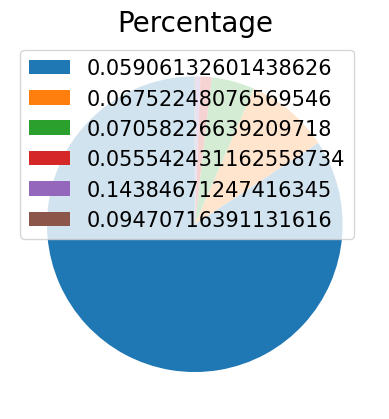

In [ ]:
k = list(X_train.columns.copy())
sensitive_features = k[3:5]
sensitive_features

counts = X_train['ethnicity'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Percentage",size=20)



Text(0.5, 1.0, 'Percentage')

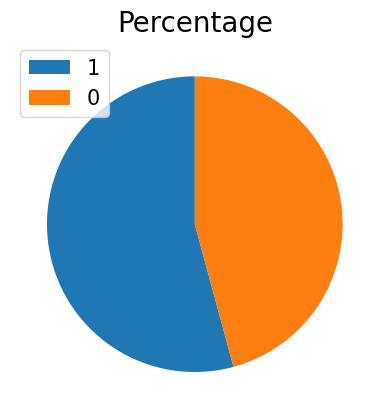

In [ ]:
counts_g = X_train['gender'].value_counts()
labels_g = counts_g.index

#Plot pie chart
plt.pie(counts_g, startangle=90)
plt.legend(labels_g, loc=2,fontsize=15)
plt.title("Percentage",size=20)

In [ ]:
df_fair = X_train[['ethnicity','gender']]
k = X_train['ethnicity'][3314]
#Define protected features
##
##ISSUE WITH EQUALITY OPERATOR; RESOLVE AS SOON AS POSSIBLE
##

df_fair['priv_race'] = [1 if r== k else 0 for r in df_fair['ethnicity']]
df_fair['priv_sex'] = [1 if s== 1 else 0 for s in df_fair['gender']]

#Define target variable
df_fair['y'] = y_train

In [ ]:
y_fair_xg = xg.predict(X_train.astype(int))


In [ ]:
len(y_fair_xg)

5967

In [ ]:
y_fair_lr = lr.predict(X_train)


In [ ]:
y_fair_dt = dt.predict(X_train)


In [ ]:
y_fair_rf = rf.predict(X_train)

In [ ]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

In [ ]:
df_fair['y_pred_xg'] =  y_fair_xg
df_fair['y_pred_lr'] =  y_fair_lr
df_fair['y_pred_dt'] =  y_fair_dt
df_fair['y_pred_rf'] =  y_fair_rf

In [ ]:
def fairness_metrics(df):
  """
  Calculate fairness for subgroup of population
  """

  cm = confusion_matrix(df['y'], df['y_pred_xg']) #change the y_pred to the corresponding model
  TN, FP, FN, TP = cm.ravel()
  N = TP+FP+FN+TN #Total population
  ACC = (TP+TN)/N #Accuracy
  TPR = TP/(TP+FN) # True positive rate
  FPR = FP/(FP+TN) # False positive rate
  FNR = FN/(TP+FN) # False negative rate
  PPP = (TP + FP)/N # % predicted as positive
  return np.array([ACC, TPR, FPR, FNR, PPP])




In [ ]:
#Calculate fairness metrics for race => equalized odds
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

In [ ]:
#Calculate fairness metrics for gender => equalized odds
fm_gender_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_gender_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])

#Get ratio of fairness metrics
fm_gender = fm_gender_0/fm_gender_1

In [ ]:
fm_gender_1, fm_gender_0

(array([0.97805255, 1.        , 0.02324059, 0.        , 0.07758887]),
 array([0.98096633, 1.        , 0.02040816, 0.        , 0.0863836 ]))

In [ ]:
fm_race_1, fm_race_0

(array([0.97951879, 1.        , 0.02176669, 0.        , 0.07953868]),
 array([0.97867804, 1.        , 0.02296211, 0.        , 0.09275053]))

Apache

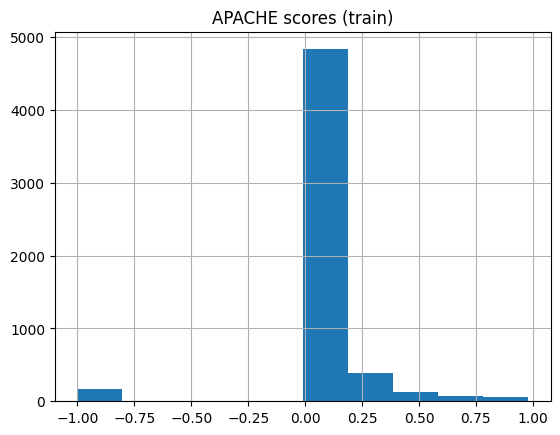

In [ ]:
 # histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

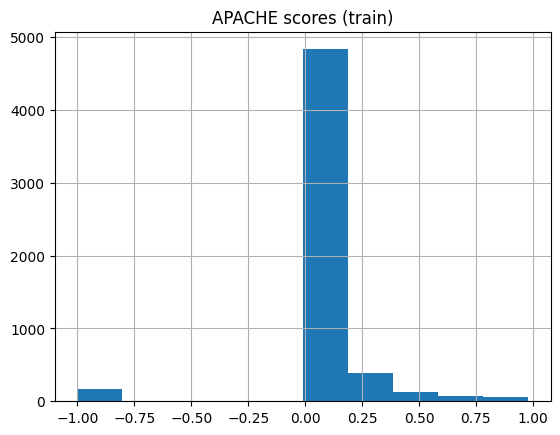

In [ ]:
 # histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

In [ ]:
y_apache_filt = y_apache_train.fillna(0)

In [ ]:
y_apache_filt = [0 if x <= 0 else x for x in y_apache_filt]

In [ ]:
y_apache_list = [1 if x >= 0.5 else 0 for x in y_apache_filt]

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lm, X_train, y_apache_list, cv=10)
scores

NameError: ignored

In [ ]:
def correlate(feature):
  df = {
    "Apache": y_apache_list,
    "Feature": X_train[feature]
  }
  data = pd.DataFrame(df)
  print(data.corr(), i)
for i in X_train.columns:
  correlate(i)

In [ ]:
comparison_df = pd.DataFrame()
comparison_df['apache_y'] = y_apache_filt
comparison_df['true_y'] = y_train

In [ ]:
comparison_df.groupby(['true_y'])

In [ ]:
print(comparison_df.corr())

In [ ]:
dt = DecisionTreeClassifier(max_depth = 1, class_weight = w)
dt.fit(np.array(y_apache_filt).reshape(-1, 1),y_train)

In [ ]:
dt.score(np.array(y_apache_filt).reshape(-1, 1),y_train)

In [ ]:
dt.get_params(deep=True)
dt.get_n_leaves()
dt.decision_path(np.array(y_apache_filt).reshape(-1, 1))

In [ ]:
from sklearn.tree import _tree

In [ ]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent,'if', name,'<=', threshold)
            recurse(tree_.children_left[node], depth + 1)
            print(indent,'if', name,'>', threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(indent, tree_.value[node])

    recurse(0, 1)

In [ ]:
tree_to_code(dt, np.array(y_apache_filt).reshape(-1, 1))

In [ ]:
low = comparison_df[comparison_df['apache_y'] > 0.1850000023841858]
low.groupby(['true_y']).count()

In [ ]:
high = comparison_df[comparison_df['apache_y'] <= 0.1850000023841858]
high.groupby(['true_y']).count()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

dt.precision_score(np.array(y_apache_filt).reshape(-1, 1),y_train)
dt.recall_score(np.array(y_apache_filt).reshape(-1, 1),y_train)